# MiniTensor Autograd, NN & Optimizers

This notebook exercises the neural network APIs, loss functions, optimizers, and autograd utilities.


In [1]:
import minitensor as mt
from minitensor import nn, optim
import numpy as np
import matplotlib.pyplot as plt

mt.manual_seed(7)
np.random.seed(7)


## Layers & activations

In [2]:
x_dense = mt.randn(4, 5)

layers = {
    "DenseLayer": nn.DenseLayer(5, 3),
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "GELU": nn.GELU(),
    "ELU": nn.ELU(),
    "LeakyReLU": nn.LeakyReLU(),
    "Softmax": nn.Softmax(dim=1),
}

for name, layer in layers.items():
    output = layer.forward(x_dense)
    print(f"{name}: shape={output.shape}")

# Convolution + batch norm + dropout on 4D input
x_conv = mt.randn(2, 3, 8, 8)
conv = nn.Conv2d(3, 4, 3)
bn2d = nn.BatchNorm2d(4)
drop2d = nn.Dropout2d(0.25)

conv_out = conv.forward(x_conv)
print("Conv2d out shape:", conv_out.shape)
print("BatchNorm2d out shape:", bn2d.forward(conv_out).shape)
print("Dropout2d out shape:", drop2d.forward(conv_out).shape)

bn1d = nn.BatchNorm1d(5)
drop1d = nn.Dropout(0.2)
print("BatchNorm1d out shape:", bn1d.forward(x_dense).shape)
print("Dropout out shape:", drop1d.forward(x_dense).shape)


DenseLayer: shape=Shape([4, 3])
ReLU: shape=Shape([4, 5])
Sigmoid: shape=Shape([4, 5])
Tanh: shape=Shape([4, 5])
GELU: shape=Shape([4, 5])
ELU: shape=Shape([4, 5])
LeakyReLU: shape=Shape([4, 5])
Softmax: shape=Shape([4, 5])
Conv2d out shape: Shape([2, 4, 6, 6])
BatchNorm2d out shape: Shape([2, 4, 6, 6])
Dropout2d out shape: Shape([2, 4, 6, 6])
BatchNorm1d out shape: Shape([4, 5])
Dropout out shape: Shape([4, 5])


## Functional NN helpers

In [3]:
dense_weight = mt.randn(3, 5)
dense_bias = mt.zeros(3)
dense_out = nn.dense_layer(x_dense, dense_weight, dense_bias)

conv_weight = mt.randn(2, 3, 3, 3)
conv_bias = mt.zeros(2)
conv_out = nn.conv2d(x_conv, weight=conv_weight, bias=conv_bias, stride=1, padding=0)

bn_out = nn.batch_norm(
    x_dense,
    running_mean=mt.zeros(5),
    running_var=mt.ones(5),
    weight=mt.ones(5),
    bias=mt.zeros(5),
    training=True,
    momentum=0.1,
    eps=1e-5,
)

drop_out = nn.dropout(x_dense, p=0.1, training=True)
drop2_out = nn.dropout2d(x_conv, p=0.1, training=True)

print("dense_layer shape:", dense_out.shape)
print("conv2d shape:", conv_out.shape)
print("batch_norm shape:", bn_out.shape)
print("dropout shape:", drop_out.shape)
print("dropout2d shape:", drop2_out.shape)


dense_layer shape: Shape([4, 3])
conv2d shape: Shape([2, 2, 6, 6])
batch_norm shape: Shape([4, 5])
dropout shape: Shape([4, 5])
dropout2d shape: Shape([2, 3, 8, 8])


## Loss functions

In [4]:
pred = mt.tensor([[0.2, -0.1, 0.5], [0.7, 0.2, -0.3]])
target_class = mt.tensor([2, 0])

losses = {
    "MSELoss": nn.MSELoss(),
    "MAELoss": nn.MAELoss(),
    "HuberLoss": nn.HuberLoss(),
    "SmoothL1Loss": nn.SmoothL1Loss(),
    "LogCoshLoss": nn.LogCoshLoss(),
}

# Regression-style targets
reg_target = mt.tensor([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])
for name, loss_fn in losses.items():
    print(f"{name}:", loss_fn.forward(pred, reg_target))

bce = nn.BCELoss()
prob = mt.tensor([[0.2, 0.7], [0.9, 0.1]])
print("BCELoss:", bce.forward(prob, mt.tensor([[0.0, 1.0], [1.0, 0.0]])))

ce = nn.CrossEntropyLoss()
print("CrossEntropyLoss:", ce.forward(pred, target_class))

focal = nn.FocalLoss()
print("FocalLoss:", focal.forward(pred, target_class))


MSELoss: tensor([0.08666666597127914])
MAELoss: tensor([0.2666666805744171])
HuberLoss: tensor([0.04333333298563957])
SmoothL1Loss: tensor([0.04333333298563957])
LogCoshLoss: tensor(0.042253971099853516)
BCELoss: tensor([0.19763490557670593])
CrossEntropyLoss: tensor([0.7543299198150635])
FocalLoss: tensor([0.017853878438472748])


## Sequential model, autograd, and optimizers

Sequential Model
Layer 0: 24 parameters (24 trainable)
Layer 1: 0 parameters (0 trainable)
Layer 2: 9 parameters (9 trainable)
Total Parameters: 33
Trainable Parameters: 33
Non-trainable Parameters: 0
Number of Layers: 3
Memory Usage: 0.13 KB (132 bytes)

num_parameters: 33
parameter_stats: {'total_parameters': 33, 'trainable_parameters': 33, 'non_trainable_parameters': 0, 'parameter_count_by_tensor': [16, 8, 8, 1]}
memory_usage: {'total_bytes': 132, 'bytes_by_dtype': {'Float32': 132}}
forward_memory_estimate: {'parameter_memory': 132, 'estimated_activation_memory': 48, 'estimated_total_memory': 180, 'input_memory': 16}
final loss: 0.03286281228065491
optimizer lr: 0.1


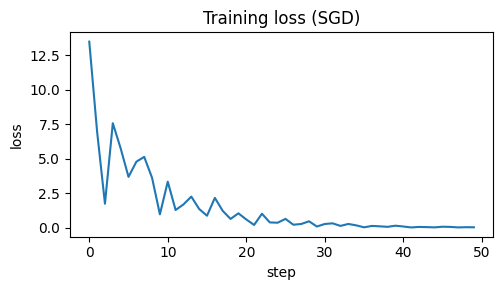

RMSprop(lr=0.01, alpha=0.99, eps=0.00000001)

In [5]:
model = nn.Sequential([
    nn.DenseLayer(2, 8),
    nn.ReLU(),
    nn.DenseLayer(8, 1),
])

print(model.summary())
print("num_parameters:", model.num_parameters())
print("parameter_stats:", model.parameter_stats())
print("memory_usage:", model.memory_usage())
print("forward_memory_estimate:", model.forward_memory_estimate([2, 2], 1))

# Simple regression dataset: y = 3x1 - 2x2 + 1
x = mt.randn(64, 2)
true_w = mt.tensor([[3.0], [-2.0]])
true_b = 1.0
y = x.matmul(true_w) + true_b

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0, nesterov=False)

loss_history = []
for _ in range(50):
    preds = model.forward(x)
    loss = criterion.forward(preds, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss.item())

print("final loss:", loss_history[-1])
print("optimizer lr:", optimizer.lr)

plt.figure(figsize=(5, 3))
plt.plot(loss_history)
plt.title("Training loss (SGD)")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
plt.show()

# Adam / AdamW / RMSprop examples
optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), epsilon=1e-8)
optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)
optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, epsilon=1e-8, weight_decay=0.0, momentum=0.0, centered=False)


## Autograd utilities

In [6]:
tensor = mt.randn(2, 2)
tensor.requires_grad_(True)
loss = (tensor * tensor).sum()
loss.backward()

print("grad property:")
print(tensor.grad)
print("has_grad:", tensor.has_grad)
print("get_gradient:")
print(mt.get_gradient(tensor))

print("autograd graph consumed:", mt.is_autograd_graph_consumed())
mt.mark_autograd_graph_consumed()
print("after mark:", mt.is_autograd_graph_consumed())
mt.clear_autograd_graph()
print("after clear:", mt.is_autograd_graph_consumed())


grad property:
tensor([[0.4013742208480835, 0.6102861762046814], [-0.955344021320343, -0.284656822681427]])
has_grad: True
get_gradient:
tensor([[0.4013742208480835, 0.6102861762046814], [-0.955344021320343, -0.284656822681427]])
autograd graph consumed: True
after mark: True
after clear: False
